
# <p style="text-align:center"> <font color='darkorange'>**CUNEF**</font>
## <p style="text-align:center"> **TFM - Análisis de sentimiento pólitico en Twitter**
### <p style="text-align:center"> **1. EDA y Selección/Preparación de variables**</strong><br />
    
<p style="text-align:left">Pablo Mazariegos Reviriego - <font color='orange'>pablo.mazariegos@cunef.edu </font>
    

En este proyecto de Trabajo Fin de Máster, realizaremos un análisis de sentimiento de los tweets hechos por los 5 candidatos políticos a la presidencia de Madrid durante el período de campaña política que abarcó desde el 12 hasta el 27 de mayo de 2023. Utilizaremos una base de datos recopilada manualmente que contiene los tweets de los candidatos. El objetivo principal de este proyecto es desarrollar modelos de aprendizaje automático que puedan clasificar los tweets según su sentimiento (positivo, negativo o neutral).

El proyecto se organizará en diferentes cuadernos, cada uno enfocado en una etapa específica del proceso:

 1. <font color='darkgreen'> **EDA y Selección/Preparación de variables**</font>
 2. Word Cloud y Análisis de viralidad
 3. Predicciones con GPT3
 4. Otros Modelos

Este cuaderno se enfoca en el análisis de datos de los tweets de los candidatos políticos durante la campaña electoral de Madrid. Realizaremos un análisis exploratorio de los datos, utilizando técnicas de visualización y evaluando el sentimiento político expresado en los tweets. Además, emplearemos un modelo de sentimiento político previamente entrenado para clasificar los tweets en categorías de sentimiento. Compartiremos nuestros resultados a través de visualizaciones informativas y resumidas, lo que nos permitirá obtener una comprensión más profunda de las opiniones y actitudes de los usuarios durante la campaña política.

  **INDICE:**
 
 - [Importación de Librerias](#0) 
 - [Funciones utilizadas en este notebook](#1) 
 - [Carga de datos](#2)
 - [Exploración de los datos](#3)
 - [Modelo de Sentimiento Pólitico](#4)
 - [Preprocesado de los tweets](#8)


  **Correlación:**
 - [Correlación de las variables](#5)
 - [Spearman](#5.1)
 - [Cramer's V](#5.2)
 - [Pearson](#5.3)
 
 
 - [Exportación de los datos](#9)


##  <a name="0"> Importación de Librerias</a>

In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
from scipy.special import softmax


import warnings
warnings.filterwarnings('ignore')

##  <a name="1">Funciones utilizadas en este notebook</a>

In [2]:
# Definimos una función para preprocesar cada tweet
def preprocess_tweet(tweet):
    # Solo procesamos si el input es de tipo string
    if isinstance(tweet, str):
        tweet = tweet.lower()  # Convertimos el tweet a minúsculas
      
        tweet_words = []
        # Recorremos cada palabra en el tweet
        for word in tweet.split(' '):
            # Si la palabra es una mención a un usuario, la reemplazamos por '@user'
            if word.startswith('@') and len(word) > 1:
                word = '@user'
            # Si la palabra es un enlace, la reemplazamos por 'http'
            elif word.startswith('http'):
                word = "http"
            # Añadimos la palabra a la lista de palabras del tweet
            tweet_words.append(word)

        # Devolvemos el tweet procesado
        return " ".join(tweet_words)
    else:
        # Si el input no es una string, devolvemos una string vacía
        return ""

In [3]:
# Definimos una función para analizar el sentimiento de un tweet
def analyze_sentiment(tweet):
    # Codificamos el tweet para que pueda ser procesado por el modelo
    encoded_tweet = tokenizer(tweet, return_tensors='pt')
    # Obtenemos las puntuaciones de sentimiento del modelo
    output = model(**encoded_tweet)
    # Convertimos las puntuaciones en un array de numpy
    scores = output[0][0].detach().numpy()
    # Convertimos las puntuaciones en probabilidades usando la función softmax
    scores = softmax(scores)
    # Devolvemos un diccionario que asocia cada etiqueta con su probabilidad
    return dict(zip(labels, scores))

In [4]:
def get_corr_matrix(dataset=None, metodo='spearman', size_figure=[10,8]):
    if dataset is None:
        print(u'\nHace falta pasar argumentos a la función')
        return 1
    sns.set(style="white")
    corr = dataset.corr(method=metodo)
    for i in range(corr.shape[0]):
        corr.iloc[i, i] = 0
    f, ax = plt.subplots(figsize=size_figure)
    sns.heatmap(corr, annot=True, fmt=".2f", square=True, linewidths=.5, cmap='coolwarm', vmin=-1, vmax=1)
    plt.show()


In [5]:
def cramers_v(var1,var2):
    """ 
    calculate Cramers V statistic for categorial-categorial association.
    uses correction from Bergsma and Wicher,
    Journal of the Korean Statistical Society 42 (2013): 323-328
    
    confusion_matrix: tabla creada con pd.crosstab()
    
    """
    crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None))
    chi2 = ss.chi2_contingency(crosstab)[0]
    n = crosstab.sum()
    phi2 = chi2 / n
    r, k = crosstab.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1),(rcorr-1)))

##  <a name="2"> Carga de datos</a>

In [34]:
df = pd.read_excel('../data/raw/tweets_12-27Mayo.xlsx', usecols=lambda x: x != 'Nº')
df.head()

,PARTIDO,CANDIDATO,NICK,FOLLOWERS,FECHA,POST,VIDEO,FOTO,REPOST,RETWEET,WHO,COMMENTS,SHARED,LIKES,VIEWED,VOTOS,PORCENTAJE,ESCAÑOS
0,PP,Isabel Díaz Ayuso,@IdiazAyuso,912100,2023-05-12,"Comenzamos la campaña, una vez más, junto a la...",SI,NO,NO,NO,NaN,198,261,1260,58700,1586985,0.4734,71
1,PP,Isabel Díaz Ayuso,@IdiazAyuso,912100,2023-05-12,"Madrid es la región del Espíritu de Ermua, la ...",NO,NO,NO,NO,NaN,550,561,2127,101600,1586985,0.4734,70
2,PP,Isabel Díaz Ayuso,@IdiazAyuso,912100,2023-05-12,"Majadahonda con ganas de Libertad, familia, un...",NO,SI,NO,NO,NaN,140,213,1042,59700,1586985,0.4734,70
3,PP,Isabel Díaz Ayuso,@IdiazAyuso,912100,2023-05-13,❤️❤️,NO,SI,SI,NO,@cayetanaAT\n,155,343,2958,159100,1586985,0.4734,70
4,PP,Isabel Díaz Ayuso,@IdiazAyuso,912100,2023-05-13,Presidente: líbranos del mal.,NO,SI,NO,NO,NaN,893,549,2592,330800,1586985,0.4734,70


##  <a name="3"> Exploración de los datos</a>

In [35]:
print('Count of rows in the data is:  ', len(df))
print('Count of columns in the data is:  ', len(df.columns))
df.info()

Count of rows in the data is:   773
Count of columns in the data is:   18
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 773 entries, 0 to 772
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   PARTIDO     773 non-null    object        
 1   CANDIDATO   773 non-null    object        
 2   NICK        773 non-null    object        
 3   FOLLOWERS   773 non-null    int64         
 4   FECHA       773 non-null    datetime64[ns]
 5   POST        771 non-null    object        
 6   VIDEO       773 non-null    object        
 7   FOTO        773 non-null    object        
 8   REPOST      773 non-null    object        
 9   RETWEET     773 non-null    object        
 10  WHO         431 non-null    object        
 11  COMMENTS    773 non-null    int64         
 12  SHARED      773 non-null    int64         
 13  LIKES       773 non-null    int64         
 14  VIEWED      773 non-null    int64         
 15  

Comprobamos el total de nulos que hay en cada columna

In [36]:
df.isnull().sum()

PARTIDO         0
CANDIDATO       0
NICK            0
FOLLOWERS       0
FECHA           0
POST            2
VIDEO           0
FOTO            0
REPOST          0
RETWEET         0
WHO           342
COMMENTS        0
SHARED          0
LIKES           0
VIEWED          0
VOTOS           0
PORCENTAJE      0
ESCAÑOS         0
dtype: int64

Se modifican los "NO" por False y "SI" por True de las columnas VIDEO, FOTO, REPOTS, RETWEET y WHO

In [37]:
df.replace({'VIDEO': {'NO': False, 'SI': True},
            'FOTO': {'NO': False, 'SI': True},
            'REPOST': {'NO': False, 'SI': True},
            'RETWEET': {'NO': False, 'SI': True},
            'WHO': {np.nan: False}}, inplace=True)

df['COMMENTS vs VIEWED'] = df['COMMENTS'] / df['VIEWED']
df['SHARED vs VIEWED'] = df['SHARED'] / df['VIEWED']
df['LIKES vs VIEWED'] = df['LIKES'] / df['VIEWED']

# Convertir la columna 'fecha' a datetime
df['FECHA'] = pd.to_datetime(df['FECHA'])

# Convertir las columnas 'video', 'repost', 'retweet' a booleanos
df['FOTO'] = df['FOTO'].astype(bool)
df['VIDEO'] = df['VIDEO'].astype(bool)
df['REPOST'] = df['REPOST'].astype(bool)
df['RETWEET'] = df['RETWEET'].astype(bool)


Visualizamos las dos filas que tienen nulos

In [38]:
df[df.isnull().any(axis=1)]

,PARTIDO,CANDIDATO,NICK,FOLLOWERS,FECHA,POST,VIDEO,FOTO,REPOST,RETWEET,...,COMMENTS,SHARED,LIKES,VIEWED,VOTOS,PORCENTAJE,ESCAÑOS,COMMENTS vs VIEWED,SHARED vs VIEWED,LIKES vs VIEWED
178,PSOE,Juan Lobato,@juanlobato_es\n,25500,2023-05-26,NaN,False,True,False,False,...,74,101,223,5460,609718,0.1819,27,0.013553,0.018498,0.040842
486,VOX,Rocío Monasterio,@monasterioR,339700,2023-05-20,NaN,True,False,False,True,...,4,119,272,28600,245215,0.0731,10,0.000140,0.004161,0.009510


En Ambos casos son fotos o repost de una foto por lo tanto eliminamos las filas

In [39]:
#Al cargar los datos crea una fila de nulos
df = df.drop([178, 486])
print('Count of rows in the data is:  ', len(df))
print('Count of columns in the data is:  ', len(df.columns))

Count of rows in the data is:   771
Count of columns in the data is:   21


**Comprobamos Duplicados**

In [40]:
df.duplicated().sum()

3

In [41]:
# Obtén un DataFrame que contiene solo las filas duplicadas
duplicated_rows = df[df.duplicated()]

# Muestra las filas duplicadas
print(duplicated_rows)

    PARTIDO          CANDIDATO               NICK  FOLLOWERS      FECHA  \
427      PP  Isabel Díaz Ayuso        @IdiazAyuso     912100 2023-05-12   
529     VOX   Rocío Monasterio       @monasterioR     339700 2023-05-25   
595    PSOE        Juan Lobato   @juanlobato_es\n      25500 2023-05-26   

                                                  POST  VIDEO   FOTO  REPOST  \
427  Comenzamos la campaña, una vez más, junto a la...   True  False   False   
529  Intenta dar lecciones de gestión y no sabe ges...   True  False   False   
595  Mi último mensaje, mi prioridad. \n\nQuiero se...   True  False   False   

     RETWEET  ... COMMENTS  SHARED  LIKES  VIEWED    VOTOS  PORCENTAJE  \
427    False  ...      198     261   1260   58700  1586985      0.4734   
529    False  ...      123     648   1619   29000   245215      0.0731   
595    False  ...      248     359    615   18100   609718      0.1819   

     ESCAÑOS  COMMENTS vs VIEWED  SHARED vs VIEWED  LIKES vs VIEWED  
427       7

No hay Duplicados relevantes.

Volvemos a comprobar los datos

In [42]:
print('Count of rows in the data is:  ', len(df))
print('Count of columns in the data is:  ', len(df.columns))
df.info()
df.isnull().sum()

Count of rows in the data is:   771
Count of columns in the data is:   21
<class 'pandas.core.frame.DataFrame'>
Int64Index: 771 entries, 0 to 772
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   PARTIDO             771 non-null    object        
 1   CANDIDATO           771 non-null    object        
 2   NICK                771 non-null    object        
 3   FOLLOWERS           771 non-null    int64         
 4   FECHA               771 non-null    datetime64[ns]
 5   POST                771 non-null    object        
 6   VIDEO               771 non-null    bool          
 7   FOTO                771 non-null    bool          
 8   REPOST              771 non-null    bool          
 9   RETWEET             771 non-null    bool          
 10  WHO                 771 non-null    object        
 11  COMMENTS            771 non-null    int64         
 12  SHARED              771 non-null

PARTIDO               0
CANDIDATO             0
NICK                  0
FOLLOWERS             0
FECHA                 0
POST                  0
VIDEO                 0
FOTO                  0
REPOST                0
RETWEET               0
WHO                   0
COMMENTS              0
SHARED                0
LIKES                 0
VIEWED                0
VOTOS                 0
PORCENTAJE            0
ESCAÑOS               0
COMMENTS vs VIEWED    0
SHARED vs VIEWED      0
LIKES vs VIEWED       0
dtype: int64

##  <a name="4">Modelo de Sentimiento Pólitico</a>

Para añadir el sentimiento de los Post, utilizo un modelo ya entrenado "cardiffnlp/xlm-twitter-politics-sentiment".

Esta es una "extensión" del modelo multilingüe twitter-xlm-roberta-base-sentiment (modelo, artículo original) con un enfoque en el sentimiento de los tweets de los políticos. El ajuste fino del sentimiento original se realizó en 8 idiomas (Ar, En, Fr, De, Hi, It, Sp, Pt), pero se realizó un entrenamiento adicional utilizando tweets de Miembros del Parlamento del Reino Unido (inglés), España (español) y Grecia (griego). Este modelo cuenta con datos hasta el año 2021.

**Se puede encontrar aqui:** https://huggingface.co/cardiffnlp/xlm-twitter-politics-sentiment

**Modelo base Roberta** 

Este es un modelo multilingüe XLM-roBERTa-base entrenado en aproximadamente 198 millones de tweets y afinado para el análisis de sentimientos. El ajuste fino del sentimiento se realizó en 8 idiomas (Ar, En, Fr, De, Hi, It, Sp, Pt), pero puede utilizarse para más idiomas (ver el artículo para más detalles). Este modelo ha sido entrenado con datos hasta el año 2020.

**Se puede encontrar aqui:** https://huggingface.co/cardiffnlp/twitter-xlm-roberta-base-sentiment

In [15]:
# Definimos el nombre del modelo pre-entrenado que vamos a utilizar
MODEL = "cardiffnlp/xlm-twitter-politics-sentiment"

# Cargamos el modelo para la clasificación de secuencias 
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# Cargamos el tokenizador asociado a este modelo
tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [16]:
# Extraemos la columna 'POST' del DataFrame original para trabajar con ella
df_post = df['POST']

# Definimos las etiquetas que usará el modelo para la clasificación
labels = ['Negative', 'Neutral', 'Positive']

In [17]:
# Aplicamos la función de preprocesamiento a cada tweet
df_post['processed_text'] = df_post.apply(preprocess_tweet)

In [18]:
# Aplicamos la función de análisis de sentimiento a cada tweet procesado
df_post['sentiment_analysis'] = df_post['processed_text'].apply(analyze_sentiment)

In [19]:
# Aquí estamos tomando la columna 'sentiment_analysis' del DataFrame df_post,
# que contiene diccionarios, y la estamos convirtiendo en un DataFrame llamado
# 'sentimiento_df'. Cada clave en los diccionarios se convierte en una columna en el
# nuevo DataFrame. Esto se logra con el método apply(pd.Series).
sentimiento_df = df_post['sentiment_analysis'].apply(pd.Series)

# Aquí añadimos una nueva columna llamada 'sentimiento' al DataFrame sentimiento_df.
# Para cada fila, el valor de esta nueva columna se determina usando el método
# idxmax(axis=1). Este método devuelve el nombre de la columna que tiene el valor
# más alto en esa fila. En otras palabras, estamos seleccionando el sentimiento
# (Negative, Neutral, Positive) que tiene la probabilidad más alta de acuerdo con
# el análisis de sentimientos realizado anteriormente.
sentimiento_df['sentimiento'] = sentimiento_df.idxmax(axis=1)

# Finalmente, mostramos las primeras filas del DataFrame para verificar que todo se haya
# realizado correctamente.
sentimiento_df.head()

,Negative,Neutral,Positive,sentimiento
0,0.034475,0.037882,0.927643,Positive
1,0.904359,0.060345,0.035295,Negative
2,0.014554,0.021517,0.963929,Positive
3,0.005584,0.010402,0.984014,Positive
4,0.680318,0.128941,0.190741,Negative


##  <a name="8"> Preprocesado de los tweets</a>

In [43]:
df = pd.concat([df, sentimiento_df], axis=1)

In [45]:
df['post_clean'] = df['POST'].copy()

In [47]:
df['sentimiento_num'] = df['sentimiento'].copy()

In [49]:
# Convierte la columna post a minusculas
df['post_clean'] = df['post_clean'].str.lower()

# Borramos los usuarios de los posts
df['post_clean'] = df['post_clean'].str.replace('@[^\s]+','')

# Borrado de signos de puntuación
df['post_clean'] = df['post_clean'].str.replace('[^\w\s]','')

# Borrado de emojis
df['post_clean'] = df['post_clean'] .str.replace('[^\x00-\x7F]+','')

# Borrado de Links
df['post_clean'] = df['post_clean'].str.replace('http\S+|www.\S+','')

df['post_clean'].head()

0    comenzamos la campaa una vez ms junto a la agr...
1    madrid es la regin del espritu de ermua la que...
2    majadahonda con ganas de libertad familia unid...
3                                                     
4                           presidente lbranos del mal
Name: post_clean, dtype: object

In [51]:
# Convierto el sentimiento a valores numericos.

df['sentimiento_num'] = df['sentimiento_num'].map({'Neutral': 0, 'Positive': 1, 'Negative': -1})


In [54]:
# Definir el mapeo de partidos a valores numéricos
partidos_numericos = {'MÁS MADRID': 0, 'VOX': 1, 'PODEMOS': 2, 'PSOE': 3, 'PP': 4}

# Crear una nueva columna numérica a partir de la columna de partidos
df['partido_num'] = df['PARTIDO'].map(partidos_numericos)

In [56]:
#Reorganización de las columnas
column_order = ['PARTIDO', 'partido_num', 'CANDIDATO', 'NICK', 'FOLLOWERS', 'FECHA', 'POST', 'post_clean', 'sentimiento', 'sentimiento_num', 'Negative', 'Neutral', 'Positive', 'VIDEO', 'FOTO', 'REPOST', 'RETWEET', 'VIEWED',
                'COMMENTS', 'COMMENTS vs VIEWED', 'SHARED', 'SHARED vs VIEWED', 'LIKES', 'LIKES vs VIEWED', 'VOTOS',
                'PORCENTAJE', 'ESCAÑOS']

df = df.reindex(columns=column_order)

In [58]:
# Convertir los nombres de las columnas a minúsculas
df.columns = df.columns.str.lower()

Última visualización del data Frame antes de su exportación

In [59]:
df.head()

,partido,partido_num,candidato,nick,followers,fecha,post,post_clean,sentimiento,sentimiento_num,...,viewed,comments,comments vs viewed,shared,shared vs viewed,likes,likes vs viewed,votos,porcentaje,escaños
0,PP,4,Isabel Díaz Ayuso,@IdiazAyuso,912100,2023-05-12,"Comenzamos la campaña, una vez más, junto a la...",comenzamos la campaa una vez ms junto a la agr...,Positive,1,...,58700,198,0.003373,261,0.004446,1260,0.021465,1586985,0.4734,71
1,PP,4,Isabel Díaz Ayuso,@IdiazAyuso,912100,2023-05-12,"Madrid es la región del Espíritu de Ermua, la ...",madrid es la regin del espritu de ermua la que...,Negative,-1,...,101600,550,0.005413,561,0.005522,2127,0.020935,1586985,0.4734,70
2,PP,4,Isabel Díaz Ayuso,@IdiazAyuso,912100,2023-05-12,"Majadahonda con ganas de Libertad, familia, un...",majadahonda con ganas de libertad familia unid...,Positive,1,...,59700,140,0.002345,213,0.003568,1042,0.017454,1586985,0.4734,70
3,PP,4,Isabel Díaz Ayuso,@IdiazAyuso,912100,2023-05-13,❤️❤️,,Positive,1,...,159100,155,0.000974,343,0.002156,2958,0.018592,1586985,0.4734,70
4,PP,4,Isabel Díaz Ayuso,@IdiazAyuso,912100,2023-05-13,Presidente: líbranos del mal.,presidente lbranos del mal,Negative,-1,...,330800,893,0.002700,549,0.001660,2592,0.007836,1586985,0.4734,70


# **Correlación**

 ##  <a name="5"> Correlación de las variables</a> 

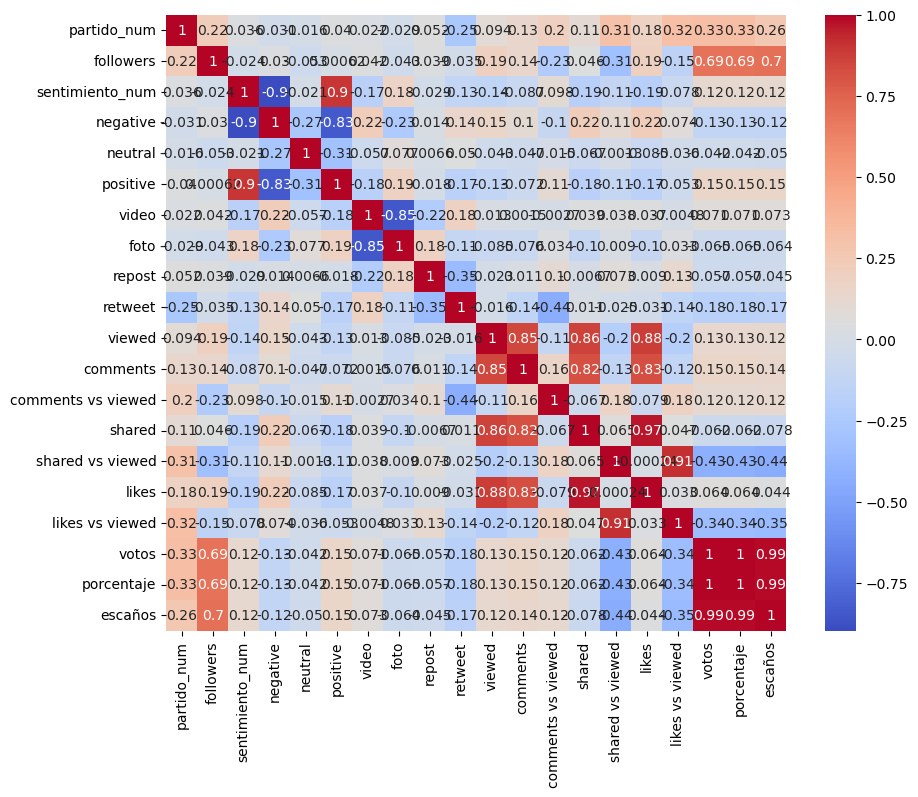

In [60]:
plt.figure(figsize=(10, 8))  # Tamaño personalizado en pulgadas (ancho, alto)
correlation = df.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.show()

## <a name="5.1">Spearman</a> 

In [63]:
df_spearman = df[['partido', 'partido_num', 'candidato', 'nick', 'followers', 'fecha',
       'post', 'post_clean', 'sentimiento', 'sentimiento_num', 'negative', 'neutral', 'positive', 'video',
       'foto', 'repost', 'retweet', 'viewed', 'comments', 'comments vs viewed',
       'shared', 'shared vs viewed', 'likes', 'likes vs viewed', 'votos',
       'porcentaje', 'escaños']]

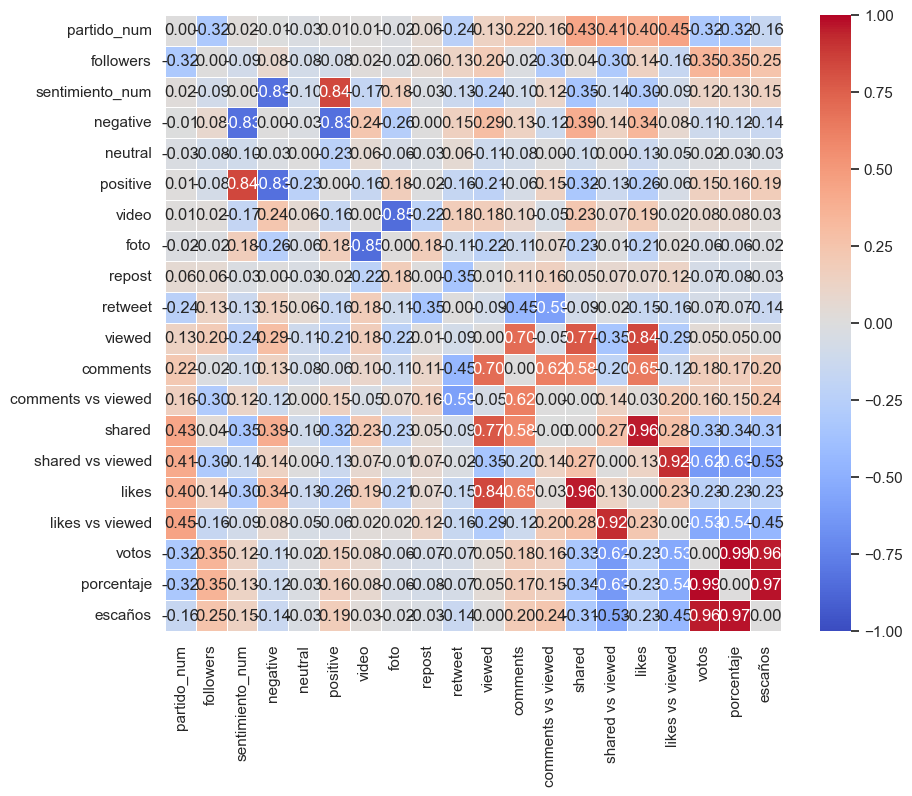

In [64]:
get_corr_matrix(dataset = df_spearman, size_figure = [10,8])

In [65]:
spearman = df_spearman.corr(method = 'spearman')
print(spearman)

                    partido_num  followers  sentimiento_num  negative  \
partido_num            1.000000  -0.316844         0.019655 -0.005294   
followers             -0.316844   1.000000        -0.090388  0.081442   
sentimiento_num        0.019655  -0.090388         1.000000 -0.829299   
negative              -0.005294   0.081442        -0.829299  1.000000   
neutral               -0.028903  -0.079308        -0.097356 -0.028680   
positive               0.014903  -0.077481         0.842995 -0.834902   
video                  0.010952   0.021063        -0.173548  0.236624   
foto                  -0.019667  -0.018294         0.175153 -0.258944   
repost                 0.061451   0.057898        -0.029297  0.002639   
retweet               -0.236568   0.125638        -0.125759  0.152096   
viewed                 0.133321   0.200869        -0.236626  0.289961   
comments               0.223502  -0.016398        -0.098143  0.133215   
comments vs viewed     0.161251  -0.295089         

## <a name="5.2">Cramer's V</a> 

In [66]:
df_categorical_variables = df[['partido', 'partido_num', 'candidato', 'nick', 'sentimiento', 'sentimiento_num', 'video',
                                               'foto', 'repost', 'retweet']]


<Axes: >

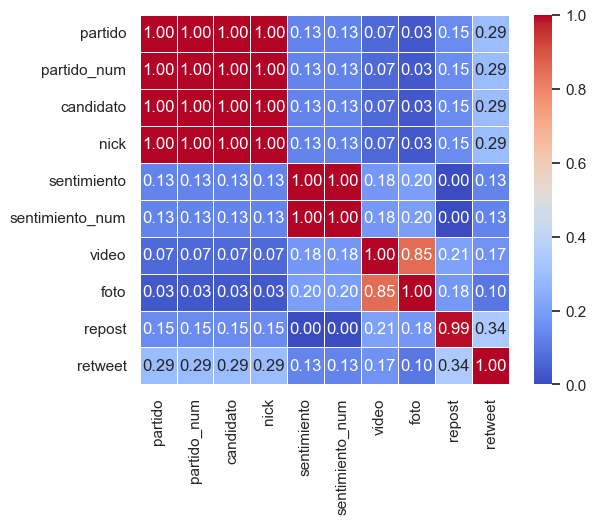

In [67]:
rows = []
for var1 in df_categorical_variables :
  col = []
  for var2 in df_categorical_variables :
    cramers = cramers_v(df_categorical_variables[var1], df_categorical_variables[var2]) # Cramer's V test
    col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
  rows.append(col)
  
cramers_results = np.array(rows)
df_vcramer = pd.DataFrame(cramers_results, columns = df_categorical_variables .columns,
                          index = df_categorical_variables .columns)

sns.heatmap(df_vcramer, vmin=0, vmax=1, square=True, annot=True, linewidths=.5, cmap='coolwarm', fmt=".2f")


In [68]:
df_vcramer

,partido,partido_num,candidato,nick,sentimiento,sentimiento_num,video,foto,repost,retweet
partido,1.00,1.00,1.00,1.00,0.13,0.13,0.07,0.03,0.15,0.29
partido_num,1.00,1.00,1.00,1.00,0.13,0.13,0.07,0.03,0.15,0.29
candidato,1.00,1.00,1.00,1.00,0.13,0.13,0.07,0.03,0.15,0.29
nick,1.00,1.00,1.00,1.00,0.13,0.13,0.07,0.03,0.15,0.29
sentimiento,0.13,0.13,0.13,0.13,1.00,1.00,0.18,0.20,0.00,0.13
sentimiento_num,0.13,0.13,0.13,0.13,1.00,1.00,0.18,0.20,0.00,0.13
video,0.07,0.07,0.07,0.07,0.18,0.18,1.00,0.85,0.21,0.17
foto,0.03,0.03,0.03,0.03,0.20,0.20,0.85,1.00,0.18,0.10
repost,0.15,0.15,0.15,0.15,0.00,0.00,0.21,0.18,0.99,0.34
retweet,0.29,0.29,0.29,0.29,0.13,0.13,0.17,0.10,0.34,1.00


##  <a name="5.3">Pearson</a>

In [69]:
df_continous_vairables = df[['followers', 'negative', 'neutral', 'positive', 'viewed', 'comments', 'comments vs viewed',
       'shared', 'shared vs viewed', 'likes', 'likes vs viewed', 'votos',
       'porcentaje', 'escaños']]
df_continous_vairables.head()

,followers,negative,neutral,positive,viewed,comments,comments vs viewed,shared,shared vs viewed,likes,likes vs viewed,votos,porcentaje,escaños
0,912100,0.034475,0.037882,0.927643,58700,198,0.003373,261,0.004446,1260,0.021465,1586985,0.4734,71
1,912100,0.904359,0.060345,0.035295,101600,550,0.005413,561,0.005522,2127,0.020935,1586985,0.4734,70
2,912100,0.014554,0.021517,0.963929,59700,140,0.002345,213,0.003568,1042,0.017454,1586985,0.4734,70
3,912100,0.005584,0.010402,0.984014,159100,155,0.000974,343,0.002156,2958,0.018592,1586985,0.4734,70
4,912100,0.680318,0.128941,0.190741,330800,893,0.002700,549,0.001660,2592,0.007836,1586985,0.4734,70


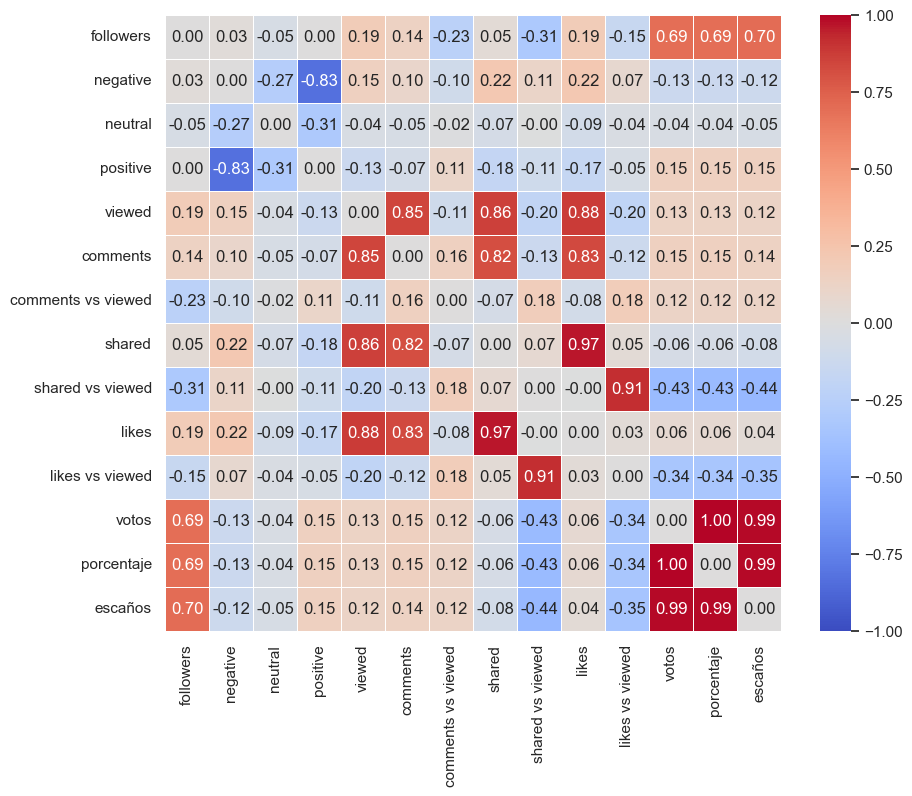

In [70]:
get_corr_matrix(dataset = df_continous_vairables,
                metodo = 'pearson', size_figure = [10,8])

##  <a name="9"> Exportación de los datos</a>

Seexportan los datos como "df_sentimiento" y en la carpeta de preprocesado

In [71]:
df.to_csv('../data/processed/df_sentimiento.csv')